## Packages and Data

Read in and clean the 'Housing Price Gap' Data

In [1]:
import pandas as pd # Needed for reading csv
import numpy as np # Needed for setting : to nan
import matplotlib.pyplot as plt # For graphing
import seaborn as sns # For fancy plots
from matplotlib.lines import Line2D # For manual legend elements
import scipy.stats as sps # For means comparison# calculating VIF
# Functions for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sms # For regression
# For clustering
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.preprocessing import StandardScaler # For standardisation

In [2]:
raw_ratio = pd.read_csv('Data/House_Price_Wages_Ratio.csv', # Read in the csv for the ratio data
                        encoding = 'utf-8')
raw_ratio.columns

Index(['New Code', 'Old Code', 'Area', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020'],
      dtype='object')

In [3]:
# Desired columns only
# Keep the "Old Code" becuase the tourism spend data doesn't have the new code
# This will allow a separate join on this column to work for this dataset
ratio = raw_ratio[['New Code','Old Code','Area','2019']].dropna().rename(columns={
    'New Code': 'Area_Code',
    'Old Code': 'Old_Code',
    '2019': 'House_Earnings_Ratio'})
ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
1,E09000001,00AA,City of London,:
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59


In [4]:
# Get rid of 'City of London' value, which has an NaN stored as ':'
ratio = ratio.drop(ratio[ratio.House_Earnings_Ratio == ':'].index)
# Get rid of 'London' from the bottom
ratio = ratio.drop(ratio[ratio.Area == 'London'].index)

ratio.head()

,Area_Code,Old_Code,Area,House_Earnings_Ratio
2,E09000002,00AB,Barking and Dagenham,10.75
3,E09000003,00AC,Barnet,14.19
4,E09000004,00AD,Bexley,9.61
5,E09000005,00AE,Brent,15.59
6,E09000006,00AF,Bromley,10.73


In [5]:
# Convert the column to floats, so that it can be plotted
ratio['House_Earnings_Ratio'] = pd.to_numeric(ratio['House_Earnings_Ratio'])
ratio.dtypes

Area_Code                object
Old_Code                 object
Area                     object
House_Earnings_Ratio    float64
dtype: object

In [6]:
raw_rental = pd.read_excel('Data/Rental_Rates.xls', # Read in the excel sheet
                           sheet_name = 'Table2.7')
# There's loads of junk at the top, with the column headings I want on row five
# I save the row I want as a variable to assign as the index labels later
header_row = raw_rental.iloc[5]

In [7]:
# Drop the first five rows, including the row we want as the index labels, so its not repeated
rental_cleaned = raw_rental.drop(list(range(6)))
rental_cleaned.columns = header_row # Assign the row from before as index labels
rental_cleaned.head()

5,NaN,LA Code1,Area Code1,Area,Count of rents,Mean,Lower quartile,Median,Upper quartile
6,NaN,NaN,E92000001,ENGLAND,480750,898,585,755,1050
7,NaN,NaN,E12000001,NORTH EAST,23690,572,425,500,625
8,NaN,1355,E06000047,County Durham UA,5650,516,400,475,550
9,NaN,1350,E06000005,Darlington UA,2300,501,400,450,550
10,NaN,724,E06000001,Hartlepool UA,800,494,415,495,550


In [8]:
# Pick out the desired columns and relabel them
# I must make sure all dataframes have the area codes stored under "Area_Code" for merging
rental_data = rental_cleaned[['Area Code1','Count of rents','Mean']].rename(columns={
    'Area Code1': 'Area_Code',
    'Count of rents':'Rent_Count',
    'Mean':'Rent_Price_Mean'})
rental_data.head()

# NOTE: This dataset includes all other administrative areas in the UK as well

5,Area_Code,Rent_Count,Rent_Price_Mean
6,E92000001,480750,898
7,E12000001,23690,572
8,E06000047,5650,516
9,E06000005,2300,501
10,E06000001,800,494


In [9]:
raw_open_space = pd.read_csv('Data/Open_Space.csv', # Read in the csv
                        encoding = 'utf-8')
raw_open_space.columns

Index(['Ward_GSS_CODE', 'Ward_NAME', 'BOROUGH_LB_GSS_CD', 'BOROUGH_Name',
       'Total area of ward (sq m)', 'All Open Space', '% open space',
       'Open Space with access', '% Open Space with access',
       '% of open space that has access'],
      dtype='object')

In [10]:
# Select desired columns and rename, keeping Area_Code consistent
open_space = raw_open_space[['Ward_GSS_CODE',
                             'Total area of ward (sq m)',
                             '% open space']].rename(columns={
    'Ward_GSS_CODE':'Area_Code',
    'Total area of ward (sq m)': 'Land_Area(m^2)',
    '% open space':'%Open_Space_2013'})
# I have to remove the commas in the land area data and convert it to a float
open_space['Land_Area(m^2)'] = open_space['Land_Area(m^2)'].str.replace(',','').astype('float')

In [11]:
open_space.head()

# NOTE: All the wards are in the dataframe as well, with the boroughs at the bottom
# The area code will serve as a unique identify for the boroughs and filter out the wards

,Area_Code,Land_Area(m^2),%Open_Space_2013
0,E05000026,1282926.0,21.9
1,E05000027,1364442.0,20.6
2,E05000028,1288085.0,1.9
3,E05000029,3384193.0,56.0
4,E05000030,3450576.0,50.4


In [12]:
raw_tourism_spend = pd.read_csv('Data/Tourism_Spend_2009.csv', # Read in the csv
                                encoding = 'utf-8')
raw_tourism_spend.columns

Index(['Code', 'Area', 'Overseas visitors (£ millions)',
       'Domestic visitors (£ millions)', 'Day visitors (£ millions)'],
      dtype='object')

In [13]:
# I need to sum the two values fir international and domestic spend together first
raw_tourism_spend.dtypes

Code                              object
Area                              object
Overseas visitors (£ millions)    object
Domestic visitors (£ millions)    object
Day visitors (£ millions)         object
dtype: object

In [14]:
tourism_spend_processed = raw_tourism_spend
tourism_spend_processed['Overseas visitors (£ millions)'] = tourism_spend_processed['Overseas visitors (£ millions)'].str.replace(',','').astype('float')
tourism_spend_processed['Domestic visitors (£ millions)'] = tourism_spend_processed['Domestic visitors (£ millions)'].str.replace(',','').astype('float')

In [15]:
tourism_spend_processed['Tourism_Spend_2009(£m)'] = sum((tourism_spend_processed['Overseas visitors (£ millions)'],
                                                    tourism_spend_processed['Domestic visitors (£ millions)']))
tourism_spend_processed.dtypes

Code                               object
Area                               object
Overseas visitors (£ millions)    float64
Domestic visitors (£ millions)    float64
Day visitors (£ millions)          object
Tourism_Spend_2009(£m)            float64
dtype: object

In [16]:
# Note, this has the old area codes
tourism_spend_2009 = raw_tourism_spend[['Code',
                             'Tourism_Spend_2009(£m)']].rename(columns={
    'Code':'Old_Code'})

## Data Joining

In [17]:
# Now I'm ready to start joining the data
y_with_tourism = ratio.merge(tourism_spend_2009, on='Old_Code', how='inner')
# Having joined on the old code, I can now get rid of it
y_with_tourism = y_with_tourism.drop('Old_Code', axis=1)
y_with_tourism.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m)
0,E09000002,Barking and Dagenham,10.75,57.0
1,E09000003,Barnet,14.19,186.0
2,E09000004,Bexley,9.61,106.0
3,E09000005,Brent,15.59,151.0
4,E09000006,Bromley,10.73,151.0


In [18]:
# I can now merge the other two dataframes on the Area_Code column
full_independents = y_with_tourism
# I can't do them both together with merge() so have to iterate
for df in [rental_data, open_space]: 
    full_independents = full_independents.merge(df,
                                                on = 'Area_Code',
                                                how = 'inner')

full_independents.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013
0,E09000002,Barking and Dagenham,10.75,57.0,940,1227,37799325.0,33.7
1,E09000003,Barnet,14.19,186.0,2320,1448,86748312.0,37.7
2,E09000004,Bexley,9.61,106.0,850,1204,64286458.0,38.9
3,E09000005,Brent,15.59,151.0,1720,1467,43232643.0,22.3
4,E09000006,Bromley,10.73,151.0,2310,1359,150134858.0,57.4


In [19]:
# I now need to calculate the number of rentals per square kilometer
full_independents['Rents/km^2'] = 1000000 * full_independents['Rent_Count'] / full_independents['Land_Area(m^2)']
full_independents.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,Rents/km^2
0,E09000002,Barking and Dagenham,10.75,57.0,940,1227,37799325.0,33.7,24.868169
1,E09000003,Barnet,14.19,186.0,2320,1448,86748312.0,37.7,26.744036
2,E09000004,Bexley,9.61,106.0,850,1204,64286458.0,38.9,13.222069
3,E09000005,Brent,15.59,151.0,1720,1467,43232643.0,22.3,39.784752
4,E09000006,Bromley,10.73,151.0,2310,1359,150134858.0,57.4,15.386167


## Summary Statistics For Independent Variables

In [20]:
# Creates basic stats for any given set of input values
# Provide the data, the title, and the label for the y-axis on the boxplot
def summary_stats(data_col, title, label):
    print(f'\nSummary Statistics for:\n\n{title}\n\n{data_col.describe()}\n') # Summary statistics
    print('Box Plot:\n')
        # Boxplot
    plt.figure(figsize=(2,5)) 
    plt.boxplot(data_col, widths = 0.5)
    plt.ylabel(label, size=12)
    plt.xticks([]) # So no ticks appear on x axis
    plt.title(title)
    plt.show()


Summary Statistics for:

House Price to
Earnings Ratio

count    32.000000
mean     13.897187
std       3.520170
min       9.610000
25%      11.970000
50%      13.000000
75%      14.485000
max      27.640000
Name: House_Earnings_Ratio, dtype: float64

Box Plot:



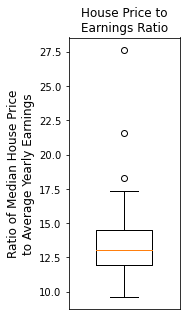


Summary Statistics for:

Tourist Expendature
(2009)

count      32.000000
mean      317.812500
std       602.590935
min        57.000000
25%       105.750000
50%       151.000000
75%       232.000000
max      3402.000000
Name: Tourism_Spend_2009(£m), dtype: float64

Box Plot:



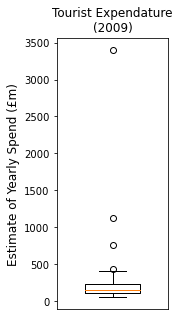


Summary Statistics for:

Rents per
Square Kilometer

count     32.000000
unique    32.000000
top       24.868169
freq       1.000000
Name: Rents/km^2, dtype: float64

Box Plot:



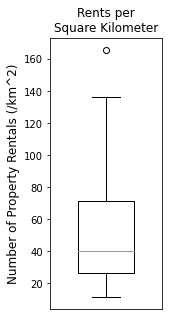


Summary Statistics for:

Open-Space Land
Percentage

count    32.000000
mean     33.487500
std      11.064204
min      13.700000
25%      26.325000
50%      32.150000
75%      38.000000
max      59.000000
Name: %Open_Space_2013, dtype: float64

Box Plot:



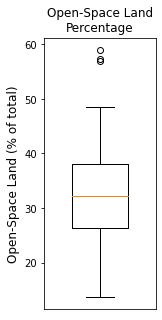

In [21]:
summary_stats(full_independents['House_Earnings_Ratio'],
              'House Price to\nEarnings Ratio',
              'Ratio of Median House Price\nto Average Yearly Earnings')

summary_stats(full_independents['Tourism_Spend_2009(£m)'],
              'Tourist Expendature\n(2009)',
              'Estimate of Yearly Spend (£m)')

summary_stats(full_independents['Rents/km^2'],
              'Rents per\nSquare Kilometer',
              'Number of Property Rentals (/km^2)')

summary_stats(full_independents['%Open_Space_2013'],
              'Open-Space Land\nPercentage',
              'Open-Space Land (% of total)')

## Dependent Variables

In [22]:
# I can now read in the data needed to calculate my dependent variable(s)
# First, the income per borough for the those living in the borough
raw_redidents_earnings = pd.read_csv('Data/Earnings_Residents.csv', # Read in the csv
                                     encoding = 'utf-8')
raw_redidents_earnings.columns

Index(['Code', 'Area', '2002', 'Unnamed: 3', '2003', 'Unnamed: 5', '2004',
       'Unnamed: 7', '2005', 'Unnamed: 9', '2006', 'Unnamed: 11', '2007',
       'Unnamed: 13', '2008', 'Unnamed: 15', '2009', 'Unnamed: 17', '2010',
       'Unnamed: 19', '2011', 'Unnamed: 21', '2012', 'Unnamed: 23', '2013',
       'Unnamed: 25', '2014', 'Unnamed: 27', '2015', 'Unnamed: 29', '2016',
       'Unnamed: 31', '2017', 'Unnamed: 33', '2018', 'Unnamed: 35', '2019',
       'Unnamed: 37', '2020', 'Unnamed: 39'],
      dtype='object')

In [23]:
# Remove the unnamed columns (these are the confidence intervals we don't need)
residents_earnings_processed = raw_redidents_earnings.loc[:,~raw_redidents_earnings.columns.str.match('Unnamed')]
# Get rid of the head junk
residents_earnings_processed = residents_earnings_processed.drop([0,1,2])
residents_earnings_processed.head()

,Code,Area,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
3,00AB,Barking and Dagenham,383.3,354.9,360.1,375.1,417.6,446.7,449.9,448.8,...,452.1,450.0,441.2,422.5,436.6,462.2,461.0,479.1,471.0,500.4
4,00AC,Barnet,427.4,450.1,453.3,442.3,466.1,460.0,502.2,528.1,...,498.3,503.1,517.5,479.1,491.0,485.6,522.6,536.6,536.4,520.2
5,00AD,Bexley,405.0,431.9,438.1,452.4,443.4,469.8,483.9,486.3,...,505.1,509.1,497.9,512.6,491.1,487.0,513.0,512.7,553.4,568.3
6,00AE,Brent,368.4,359.8,395.5,394.7,398.7,421.6,437.0,439.1,...,414.9,442.0,441.8,441.8,457.6,467.0,471.0,479.9,524.0,540.7
7,00AF,Bromley,440.1,449.2,461.2,464.8,479.5,506.3,546.0,545.6,...,551.7,566.6,581.1,578.5,583.8,584.3,608.0,632.7,638.3,608.4


In [24]:
# Put the column names into a list and slice off the first two
# This columnname list will work for our second dataframe as well
colnames_to_merge = residents_earnings_processed.columns.to_list()[2:]

In [25]:
# I need the dataframe to be "long" to calculate year by year
residents_earnings_long = pd.melt(residents_earnings_processed,
                                  id_vars = ['Area'],
                                  value_vars = colnames_to_merge, # This isn't strictly necessary!
                                  var_name = 'Year',
                                  value_name = 'Average_Pay_Residents(£)')
residents_earnings_long.head()

,Area,Year,Average_Pay_Residents(£)
0,Barking and Dagenham,2002,383.3
1,Barnet,2002,427.4
2,Bexley,2002,405.0
3,Brent,2002,368.4
4,Bromley,2002,440.1


In [26]:
# Same process for the earnings according to workplace
raw_workplace_earnings = pd.read_csv('Data/Earnings_Workplace.csv', # Read in the csv
                                     encoding = 'utf-8')
raw_workplace_earnings.head()

,Unnamed: 0,Unnamed: 1,1997,Unnamed: 3,1998,Unnamed: 5,1999,Unnamed: 7,2000,Unnamed: 9,...,2016,Unnamed: 41,2017,Unnamed: 43,2018,Unnamed: 45,2019,Unnamed: 47,2020,Unnamed: 49
0,Code,Area,number,conf %,number,conf %,number,conf %,number,conf %,...,number,conf %,number,conf %,number,conf %,number,conf %,number,conf %
1,E09000001,City of London,540.1,2.5,561.5,2.0,623.8,3.0,658.5,2.9,...,958.2,2.4,987.2,2.6,"1,054.1",2.9,"1,049.5",3.1,"1,103.1",3.9
2,E09000002,Barking and Dagenham,330.0,6.0,431.3,6.3,398.1,6.2,424.0,7.6,...,580.3,7.4,605.5,6.6,579.1,5.4,569.5,7.2,586.2,10.0
3,E09000003,Barnet,334.0,5.4,356.6,4.0,366.9,5.6,381.7,7.3,...,598.6,5.2,597.5,5.7,579.0,5.4,596.0,7.0,578.7,10.0
4,E09000004,Bexley,345.8,6.4,359.1,4.7,362.4,5.0,373.3,5.1,...,559.2,4.4,575.5,5.4,591.4,5.3,613.0,4.4,541.8,7.2


In [27]:
# I can't get rid of unnamed column this time as the columns for some important variables are on lower layers
# So I first rename the important ones
workplace_earnings_processed = raw_workplace_earnings.rename(columns={
    'Unnamed: 0': 'Code',
    'Unnamed: 1': 'Area',})
workplace_earnings_processed.head()

,Code,Area,1997,Unnamed: 3,1998,Unnamed: 5,1999,Unnamed: 7,2000,Unnamed: 9,...,2016,Unnamed: 41,2017,Unnamed: 43,2018,Unnamed: 45,2019,Unnamed: 47,2020,Unnamed: 49
0,Code,Area,number,conf %,number,conf %,number,conf %,number,conf %,...,number,conf %,number,conf %,number,conf %,number,conf %,number,conf %
1,E09000001,City of London,540.1,2.5,561.5,2.0,623.8,3.0,658.5,2.9,...,958.2,2.4,987.2,2.6,"1,054.1",2.9,"1,049.5",3.1,"1,103.1",3.9
2,E09000002,Barking and Dagenham,330.0,6.0,431.3,6.3,398.1,6.2,424.0,7.6,...,580.3,7.4,605.5,6.6,579.1,5.4,569.5,7.2,586.2,10.0
3,E09000003,Barnet,334.0,5.4,356.6,4.0,366.9,5.6,381.7,7.3,...,598.6,5.2,597.5,5.7,579.0,5.4,596.0,7.0,578.7,10.0
4,E09000004,Bexley,345.8,6.4,359.1,4.7,362.4,5.0,373.3,5.1,...,559.2,4.4,575.5,5.4,591.4,5.3,613.0,4.4,541.8,7.2


In [28]:
# Remove the confidence interval columns (these are the confidence intervals we don't need)
workplace_earnings_processed = workplace_earnings_processed.loc[:,~workplace_earnings_processed.columns.str.match('Unnamed')]
# One layer of head junk this time
workplace_earnings_processed = workplace_earnings_processed.drop([0])
workplace_earnings_processed.head()

,Code,Area,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
1,E09000001,City of London,540.1,561.5,623.8,658.5,691.0,719.6,736.0,777.8,...,969.2,919.7,945.2,928.0,926.2,958.2,987.2,"1,054.1","1,049.5","1,103.1"
2,E09000002,Barking and Dagenham,330.0,431.3,398.1,424.0,404.3,467.9,493.3,517.0,...,553.8,655.5,667.9,626.2,625.8,580.3,605.5,579.1,569.5,586.2
3,E09000003,Barnet,334.0,356.6,366.9,381.7,406.7,405.4,453.1,486.6,...,572.6,554.7,563.6,575.7,583.5,598.6,597.5,579.0,596.0,578.7
4,E09000004,Bexley,345.8,359.1,362.4,373.3,385.9,395.5,421.6,374.8,...,519.9,550.8,525.2,561.4,556.0,559.2,575.5,591.4,613.0,541.8
5,E09000005,Brent,334.0,362.5,366.4,407.9,402.0,403.1,430.4,431.6,...,512.6,537.3,546.4,561.7,574.9,572.8,575.0,581.8,644.5,670.5


In [29]:
# I need the dataframe to be "long" to calculate year by year
workplace_earnings_long = pd.melt(workplace_earnings_processed,
                                  id_vars = ['Code','Area'],
                                  value_vars = colnames_to_merge, # This isn't strictly necessary!
                                  var_name = 'Year',
                                  value_name = 'Average_Pay_Workplace(£)')
workplace_earnings_long.head()

,Code,Area,Year,Average_Pay_Workplace(£)
0,E09000001,City of London,2002,719.6
1,E09000002,Barking and Dagenham,2002,467.9
2,E09000003,Barnet,2002,405.4
3,E09000004,Bexley,2002,395.5
4,E09000005,Brent,2002,403.1


In [30]:
# Now I can merge the two and create the new variable
y_merged = workplace_earnings_long.merge(residents_earnings_long,
                                         on=['Area','Year'],
                                             # Both the borough and the year have to match
                                             # I have to use "Area" because the code is old
                                         how='inner')
y_merged.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£)
0,E09000002,Barking and Dagenham,2002,467.9,383.3
1,E09000003,Barnet,2002,405.4,427.4
2,E09000004,Bexley,2002,395.5,405.0
3,E09000005,Brent,2002,403.1,368.4
4,E09000006,Bromley,2002,318.2,440.1


In [31]:
# Drop na rows and remove rows with na values
y_merged.dropna(subset = ['Average_Pay_Workplace(£)','Average_Pay_Residents(£)'])
y_merged['Average_Pay_Workplace(£)'] = y_merged['Average_Pay_Workplace(£)'].astype('float')
y_merged['Average_Pay_Residents(£)'] = y_merged['Average_Pay_Residents(£)'].astype('float')
# I also want the year stored as an integer for the graph
y_merged['Year'] = y_merged['Year'].astype('int')
# Create new column
y_merged['Residents_to_Workplace_Ratio'] = y_merged['Average_Pay_Workplace(£)'] / y_merged['Average_Pay_Residents(£)']
y_merged.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£),Residents_to_Workplace_Ratio
0,E09000002,Barking and Dagenham,2002,467.9,383.3,1.220715
1,E09000003,Barnet,2002,405.4,427.4,0.948526
2,E09000004,Bexley,2002,395.5,405.0,0.976543
3,E09000005,Brent,2002,403.1,368.4,1.094191
4,E09000006,Bromley,2002,318.2,440.1,0.723017


In [32]:
# I now need to get rid of non-London areas
y_merged = y_merged[y_merged['Code'].str.contains('E09') == True]

<AxesSubplot:xlabel='Year', ylabel='Residents_to_Workplace_Ratio'>

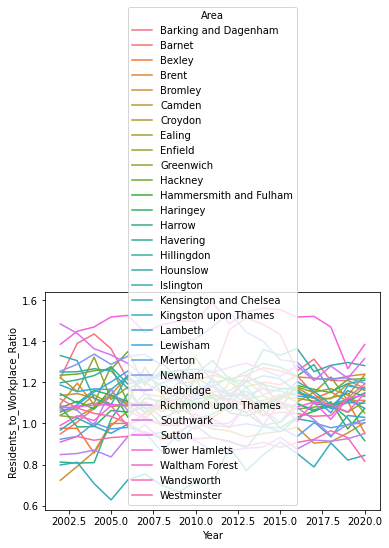

In [33]:
sns.lineplot(data=y_merged,
             x='Year',
             y='Residents_to_Workplace_Ratio',
             hue='Area')

In [34]:
change_since_2002 = y_merged[(y_merged['Year'] == 2002) | (y_merged['Year'] == 2019)]
change_since_2002.head()

,Code,Area,Year,Average_Pay_Workplace(£),Average_Pay_Residents(£),Residents_to_Workplace_Ratio
0,E09000002,Barking and Dagenham,2002,467.9,383.3,1.220715
1,E09000003,Barnet,2002,405.4,427.4,0.948526
2,E09000004,Bexley,2002,395.5,405.0,0.976543
3,E09000005,Brent,2002,403.1,368.4,1.094191
4,E09000006,Bromley,2002,318.2,440.1,0.723017


In [35]:
# Now I can pivot the table so I can create a 'difference' column
ratio_difference = change_since_2002.pivot(index = 'Code',
                                               # So 'Code' is kept (but I don't want it as the index ultimately)
                                           columns = 'Year', # Break apart the 'Year' column
                                           # I want the code as a column, not the index
                                           values = 'Residents_to_Workplace_Ratio').reset_index()
ratio_difference = ratio_difference.rename(columns={
    'Code': 'Area_Code',
    2002:'rtw_earnings_ratio_02',
    2019:'rtw_earnings_ratio_19'})
ratio_difference.columns                            

Index(['Area_Code', 'rtw_earnings_ratio_02', 'rtw_earnings_ratio_19'], dtype='object', name='Year')

In [36]:
# Calculate the new column with the percentage change of the ratio of average residents' earnings to average workers' earnings
ratio_difference['rtw_earnings_ratio_change_02-19'] = 100 * (ratio_difference['rtw_earnings_ratio_19'] - ratio_difference['rtw_earnings_ratio_02']) / ratio_difference['rtw_earnings_ratio_02']
ratio_difference.head()

Year,Area_Code,rtw_earnings_ratio_02,rtw_earnings_ratio_19,rtw_earnings_ratio_change_02-19
0,E09000002,1.220715,1.209130,-0.949061
1,E09000003,0.948526,1.111111,17.140821
2,E09000004,0.976543,1.107698,13.430502
3,E09000005,1.094191,1.229962,12.408320
4,E09000006,0.723017,0.953783,31.917069


In [37]:
# Now I can merge this value to the big dataframe
full_data = full_independents.merge(ratio_difference,
                                    on = 'Area_Code', # Join this column
                                    how = 'inner') # Keep only the shared rows
full_data.head()

,Area_Code,Area,House_Earnings_Ratio,Tourism_Spend_2009(£m),Rent_Count,Rent_Price_Mean,Land_Area(m^2),%Open_Space_2013,Rents/km^2,rtw_earnings_ratio_02,rtw_earnings_ratio_19,rtw_earnings_ratio_change_02-19
0,E09000002,Barking and Dagenham,10.75,57.0,940,1227,37799325.0,33.7,24.868169,1.220715,1.209130,-0.949061
1,E09000003,Barnet,14.19,186.0,2320,1448,86748312.0,37.7,26.744036,0.948526,1.111111,17.140821
2,E09000004,Bexley,9.61,106.0,850,1204,64286458.0,38.9,13.222069,0.976543,1.107698,13.430502
3,E09000005,Brent,15.59,151.0,1720,1467,43232643.0,22.3,39.784752,1.094191,1.229962,12.408320
4,E09000006,Bromley,10.73,151.0,2310,1359,150134858.0,57.4,15.386167,0.723017,0.953783,31.917069


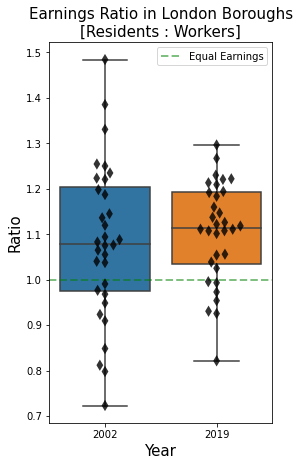

In [38]:
# Now I can plot the two years' distributions against each other
fig, ax = plt.subplots(1,1, figsize = (4,7)) # Set axes and figure

# Boxplot
sns.boxplot(data = full_data[['rtw_earnings_ratio_02','rtw_earnings_ratio_19']],
            ax = ax)
# Swarmplot over the top
sns.swarmplot(data = full_data[['rtw_earnings_ratio_02','rtw_earnings_ratio_19']],
              color = 'black',
              size = 8,
              marker = 'd',
              alpha = 0.8,
              ax = ax)
# Horizontal line for y=1
plt.axhline(y = 1,
            color='g',
            linestyle='--',
            lw = 2,
            alpha = 0.5)
# Legend (assign 2D Line to match the line on the graph)
plt.legend(handles = [Line2D([0],[0], linewidth = 2, # The axis line
                             linestyle = '--',
                             color = 'g',
                             alpha = 0.5)],
           labels = ['Equal Earnings']) # Label
# Change the labels for the bars from default
ax.set_xticklabels(['2002','2019'])
# Label the axes
ax.set_xlabel('Year', size = 15)
ax.set_ylabel('Ratio', size = 15)
# Set title
plt.title('Earnings Ratio in London Boroughs\n[Residents : Workers]',
         size = 15)
plt.show()
# Save it to an output folder
fig.savefig('Figures/Earnings_Ratio.png')

## Means Comparison Test

In [39]:
# I need to check there's a real difference between the two distributions
data1 = full_data['rtw_earnings_ratio_02']
data2 = full_data['rtw_earnings_ratio_19']

min1 = data1.min()
min2 = data2.min()

max1 = data1.max()
max2 = data2.max()

mean1 = data1.mean()
mean2 = data2.mean()
# Standard deviations
std1 = data1.std()
std2 = data2.std()

n1 = len(data1)
n2 = len(data2)

In [40]:
# Step 1

# H0: Mean of population 1 =  Mean of population 1
# H1: Mean of population 1 <> Mean of population 1

# Step 2

alpha = 0.05

In [41]:
std_ratio = std1/std2

print("std_ratio =", std_ratio)

if std_ratio > 0.5 and std_ratio < 2:
    print("Can assume equal population standard deviations.")
    equal_stds = True
else:
    print("Cannot assume equal population standard deviations.")
    equal_stds = False

std_ratio = 1.5525438347793334
Can assume equal population standard deviations.


In [42]:
# Calculate the test statistic and the p-value:
# (We don't actually need the test statistic, since it is only used to calculate the p-value anyway.)

# sps.test_ind gives TWO outputs
test_stat, p_value = sps.ttest_ind(data1, data2, equal_var = equal_stds)
print("p-value =", p_value)

p-value = 0.5702736373897992


In [43]:
# Reach a conclusion:

if p_value < alpha:
    print("p-value < significance threshold.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different means.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same mean.")

p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same mean.


## KS Distribution Test

In [44]:
# H0: Sample 1 and Sample 2 are drawn from identical distributions.
# H1: Sample 1 and Sample 2 are not drawn from identical distributions.

In [45]:
# Set significance level:

alpha = 0.05

In [46]:
# Likewise, gives two outputs
KS_stat, p_value = sps.ks_2samp(data1,data2)

# Compare with the KS stat we calculated earlier:

print("KS stat =", KS_stat)
print("p-value =", p_value)

KS stat = 0.25
p-value = 0.2730080624498207


In [47]:
# Reach a conclusion:

if p_value < alpha:
    print("p-value < significance threshold.")
    print("Reject H0. Accept H1.")
    print("Conclude that samples are drawn from populations with different distributions.")
elif p_value >= alpha:
    print("p-value >= significance threshold.")
    print("No significant evidence to reject H0.")
    print("Assume samples are drawn from populations with the same distribution.")

p-value >= significance threshold.
No significant evidence to reject H0.
Assume samples are drawn from populations with the same distribution.


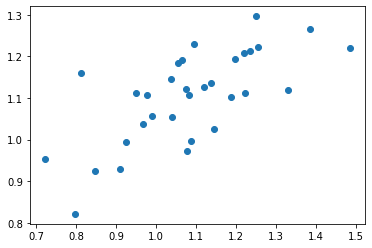

In [48]:
plt.scatter(data1, data2)

## Simple Regression

In [49]:
# Set up VIF Function
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
                            for i in range(df_with_const.shape[1])], name= "VIF",
                           index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [50]:
full_data.dtypes

Area_Code                           object
Area                                object
House_Earnings_Ratio               float64
Tourism_Spend_2009(£m)             float64
Rent_Count                          object
Rent_Price_Mean                     object
Land_Area(m^2)                     float64
%Open_Space_2013                   float64
Rents/km^2                          object
rtw_earnings_ratio_02              float64
rtw_earnings_ratio_19              float64
rtw_earnings_ratio_change_02-19    float64
dtype: object

In [51]:
# I need all the data to be floats
for column in full_data.columns[2:]:
    full_data[column] = full_data[column].astype('float')
full_data.dtypes

Area_Code                           object
Area                                object
House_Earnings_Ratio               float64
Tourism_Spend_2009(£m)             float64
Rent_Count                         float64
Rent_Price_Mean                    float64
Land_Area(m^2)                     float64
%Open_Space_2013                   float64
Rents/km^2                         float64
rtw_earnings_ratio_02              float64
rtw_earnings_ratio_19              float64
rtw_earnings_ratio_change_02-19    float64
dtype: object

In [52]:
# Define the names of the x-variable columns
x_variables = ['rtw_earnings_ratio_19',
               'Tourism_Spend_2009(£m)',
               'Rents/km^2',
               '%Open_Space_2013',
               'rtw_earnings_ratio_change_02-19']

In [53]:
def simple_regression(variable, remove_outliers = False):
    
    # Prepare data
    print(f'\nFor {variable}:\n')
    x_values = full_data[variable]
    y_values = full_data['House_Earnings_Ratio']
    X_values = sms.add_constant(x_values)
    
    # Remove outliers
    if remove_outliers == True:
        removed_values = []
        stdev = x_values.std()
        limit = 4 * stdev # Value set higher than Tukey Fences
        mean = x_values.mean()
        fences = [mean - limit, mean + limit]
        for i in range(0,len(x_values)):
            if (x_values[i] < fences[0]) | (x_values[i] > fences[1]):
                x_values = x_values.drop([i])
                y_values = y_values.drop([i])
                print(f'...Removing {full_data.Area[i]}')
                removed_values.append(i)
        print(f'\nRemoved {len(removed_values)} outlier(s)\n')
    
    X_values = sms.add_constant(x_values)
    
    #R egression
    regression_model = sms.OLS(y_values, X_values).fit()
    print(regression_model.summary())
    
    # Summary
    gradient  = regression_model.params[1]
    intercept = regression_model.params[0]
    Rsquared  = regression_model.rsquared
    MSE       = regression_model.mse_resid
    pvalue    = regression_model.f_pvalue
    print("gradient  =", gradient)
    print("intercept =", intercept)
    print("Rsquared  =", Rsquared)
    print("MSE       =", MSE)
    print("pvalue    =", pvalue)
    
    # Line of best fit
    x_lobf = [min(x_values),max(x_values)]
    y_lobf = [x_lobf[0]*gradient + intercept,x_lobf[1]*gradient + intercept]
    
    # Plot
    fig, ax = plt.subplots(1,1, figsize = (7,7))
    plt.plot(x_values,y_values,
             'g.',
             x_lobf,y_lobf,
             'r--',
             markersize=10)
    plt.xlabel(variable)
    plt.ylabel('House Price to Yearly Earnings Ratio')
    plt.title(f'Scatter Plot with Best Fit Line for {variable}')
    print('\n\n\n') # Gap before next variable
    
    # Residual Plot
    ax2 = fig.add_axes([1, 0.15, 0.6, 0.6])
    plt.scatter(regression_model.fittedvalues,
                regression_model.resid,
                c='r', s=10)
    # Adding title and labels
    plt.xlabel(f'Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted Plot for {variable}')
    plt.show()


For rtw_earnings_ratio_19:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.140
Model:                              OLS   Adj. R-squared:                  0.111
Method:                   Least Squares   F-statistic:                     4.877
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):             0.0350
Time:                          17:31:52   Log-Likelihood:                -82.760
No. Observations:                    32   AIC:                             169.5
Df Residuals:                        30   BIC:                             172.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


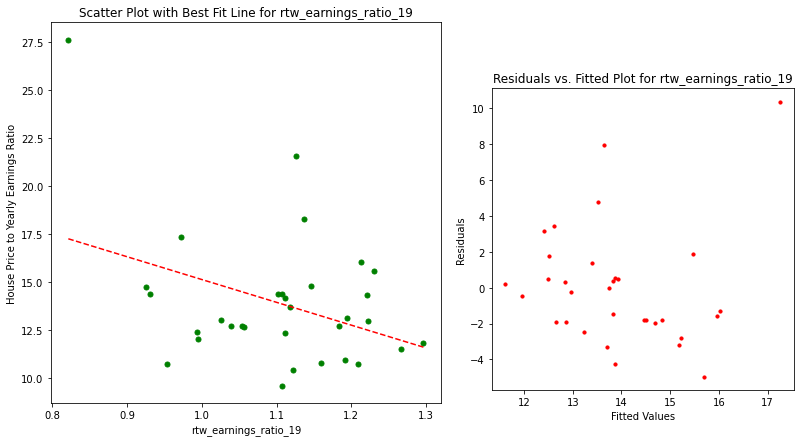


For Tourism_Spend_2009(£m):

...Removing Westminster

Removed 1 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.653
Model:                              OLS   Adj. R-squared:                  0.641
Method:                   Least Squares   F-statistic:                     54.46
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):           3.94e-08
Time:                          17:31:52   Log-Likelihood:                -63.924
No. Observations:                    31   AIC:                             131.8
Df Residuals:                        29   BIC:                             134.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


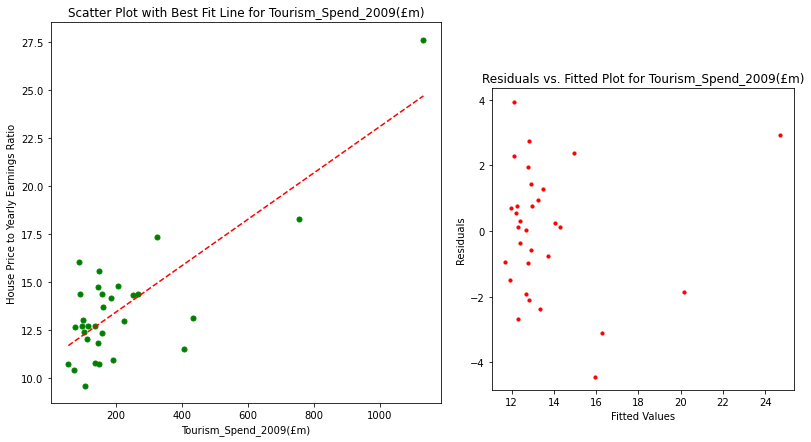


For Rents/km^2:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.455
Model:                              OLS   Adj. R-squared:                  0.437
Method:                   Least Squares   F-statistic:                     25.06
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):           2.29e-05
Time:                          17:31:52   Log-Likelihood:                -75.454
No. Observations:                    32   AIC:                             154.9
Df Residuals:                        30   BIC:                             157.8
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


 10.621149406397747
Rsquared  = 0.4551605527639717
MSE       = 6.976477463230955
pvalue    = 2.289205692753044e-05






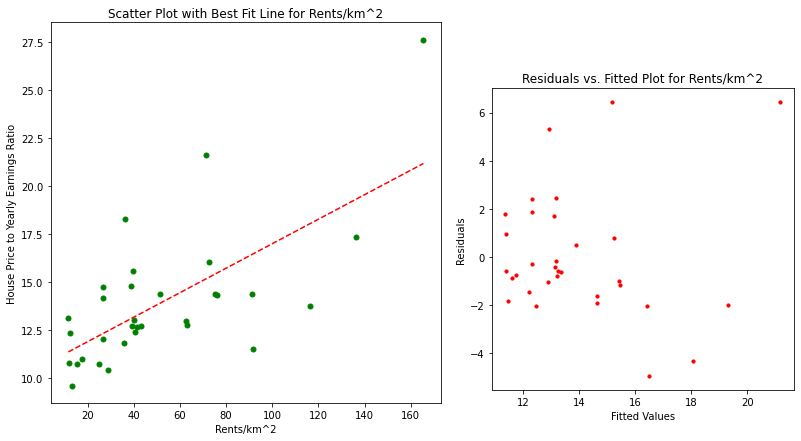


For %Open_Space_2013:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.202
Model:                              OLS   Adj. R-squared:                  0.175
Method:                   Least Squares   F-statistic:                     7.580
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):            0.00992
Time:                          17:31:52   Log-Likelihood:                -81.566
No. Observations:                    32   AIC:                             167.1
Df Residuals:                        30   BIC:                             170.1
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


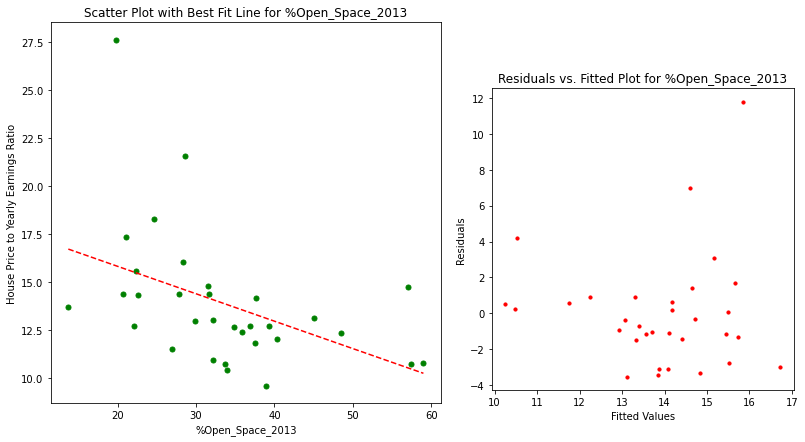


For rtw_earnings_ratio_change_02-19:


Removed 0 outlier(s)

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.011
Method:                   Least Squares   F-statistic:                     1.339
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):              0.256
Time:                          17:31:53   Log-Likelihood:                -84.472
No. Observations:                    32   AIC:                             172.9
Df Residuals:                        30   BIC:                             175.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


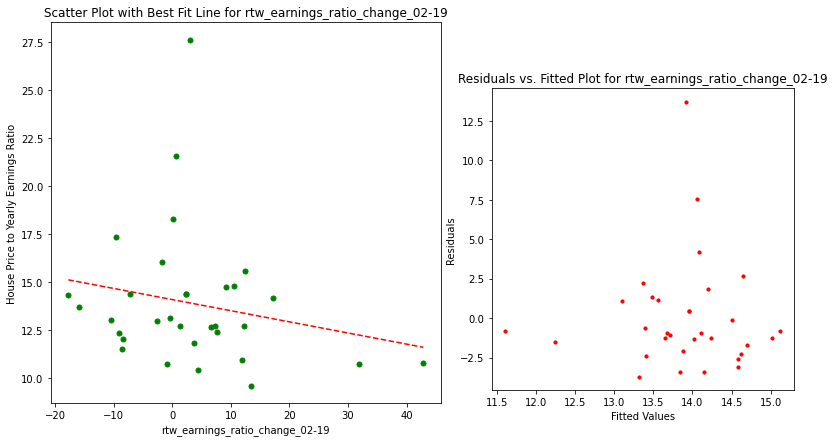

In [54]:
for x in x_variables:
    simple_regression(x, remove_outliers = True)

## Multiple Regression

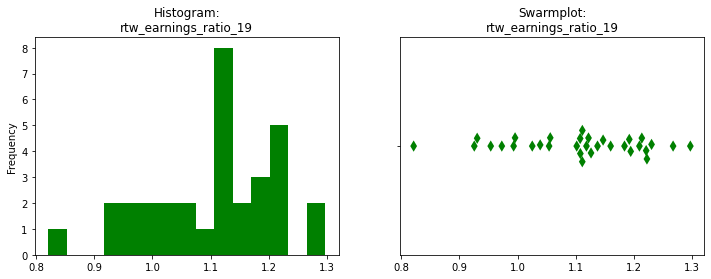

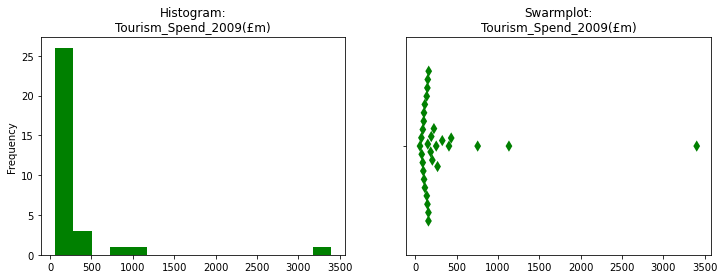

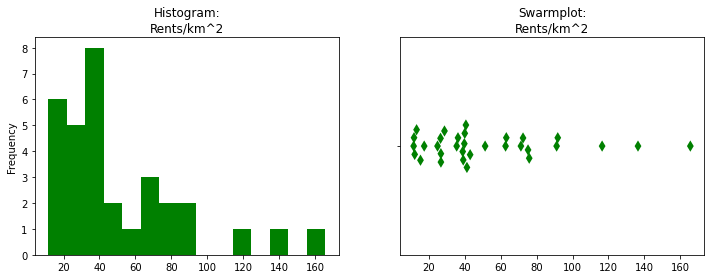

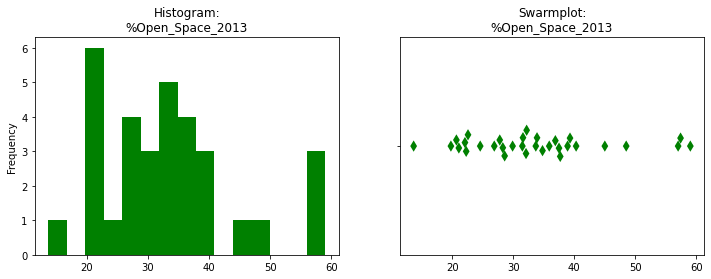

In [151]:
# Define the names of the x-variable columns
x_variables = ['rtw_earnings_ratio_19',
               #'rtw_earnings_ratio_change_02-19',
               'Tourism_Spend_2009(£m)',
               'Rents/km^2',
               '%Open_Space_2013']

for variable in x_variables:
    
    data = full_data[variable]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    plt.sca(ax1)
    plt.hist(data, color='g', bins=15)
    plt.title(f'Histogram:\n{variable}')
    plt.ylabel('Frequency')
    
    sns.swarmplot(data = data,
                  color = 'g',
                  size = 8,
                  marker = 'd',
                  orient='h',
                  ax = ax2)
    # Horizontal line for y=1
    plt.sca(ax2)
    plt.axhline(y = 1,
                color='g',
                linestyle='--',
                lw = 2,
                alpha = 0.5)
    # Set title
    plt.title(f'Swarmplot:\n{variable}')
    ax2.set_yticklabels('')
    plt.show()
    if variable == 'Rents/km^2':
        fig.savefig(f'Figures/Rents_per_km^2_Distribution_Unlogged.png')
    else:
        fig.savefig(f'Figures/{variable}_Distribution_Unlogged.png')

In [129]:
full_data['log_Tourism_Spend_2009(£m)'] = np.log(full_data['Tourism_Spend_2009(£m)'])
full_data['log_Rents/km^2'] = np.log(full_data['Rents/km^2'])

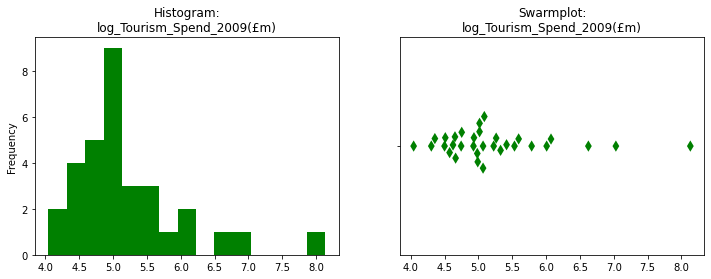

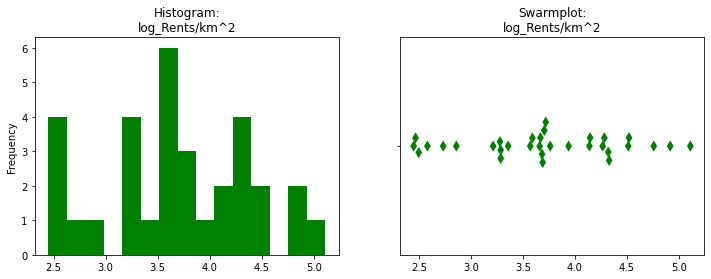

In [159]:
x_variables = ['rtw_earnings_ratio_19',
               'log_Tourism_Spend_2009(£m)',
               'log_Rents/km^2',
               '%Open_Space_2013']

for variable in [x_variables[1],x_variables[2]]:
    
    data = full_data[variable]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    
    plt.sca(ax1)
    plt.hist(data, color='g', bins=15)
    plt.title(f'Histogram:\n{variable}')
    plt.ylabel('Frequency')
    
    sns.swarmplot(data = data,
                  color = 'g',
                  size = 8,
                  marker = 'd',
                  orient='h',
                  ax = ax2)
    # Horizontal line for y=1
    plt.sca(ax2)
    plt.axhline(y = 1,
                color='g',
                linestyle='--',
                lw = 2,
                alpha = 0.5)
    # Set title
    plt.title(f'Swarmplot:\n{variable}')
    ax2.set_yticklabels('')
    plt.show()
    if variable == 'log_Rents/km^2':
        fig.savefig(f'Figures/Rents_per_km^2_Distribution_Logged.png')
    else:
        fig.savefig(f'Figures/{variable}_Distribution_Logged.png')

In [172]:
def multiple_regression(predictors):
                       
    predictors_with_VIF = drop_column_using_vif(full_data[predictors])
    print(f'Predictors Included In Model After VIF:\n\n{list(predictors_with_VIF.columns)}\n')
    
    y_values = full_data['House_Earnings_Ratio']
    X_values = sms.add_constant(predictors_with_VIF)
    regression_model = sms.OLS(y_values, X_values).fit()
    # and print a summary of the results:
    print(regression_model.summary())
    print() # blank line

    # Now we store all the relevant values:
    predictor_coeffs  = regression_model.params[1:]
    constant          = regression_model.params[0] # called the 'intercept' in simple regression
    Rsquared          = regression_model.rsquared
    MSE               = regression_model.mse_resid
    pvalues_T         = regression_model.pvalues[1:]
    pvalue_F          = regression_model.f_pvalue

    # Note that predictor_coeffs is a list of the best-fit coefficients for x1, x2, x3, ...
    # Similarly, pvalues_T is a list of the p-values associated with each of these variables in turn.

    # Print these summary stats:
    print("predictor coefficients =", predictor_coeffs)
    print("constant               =", constant)
    print("Rsquared               =", Rsquared)
    print("MSE                    =", MSE)
    print("T-test pvalues         =", pvalues_T)
    print("F-test pvalue          =", pvalue_F)
    
    # Plot the residuals vs fitted-values
    plt.scatter(regression_model.fittedvalues,
                regression_model.resid,
                c='r', s=10)
    # Horizontal line
    plt.axhline(y = 0,
                color='grey',
                linestyle='--',
                lw = 1,
                alpha = 0.4)
    # Adding title and labels
    plt.xlabel(f'Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted Plot')
    plt.savefig('Figures/Residuals_vs_Fitted_Plot.png')
    plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Predictors Included In Model After VIF:

['rtw_earnings_ratio_19', 'log_Tourism_Spend_2009(£m)', 'log_Rents/km^2', '%Open_Space_2013']

                             OLS Regression Results                             
Dep. Variable:     House_Earnings_Ratio   R-squared:                       0.757
Model:                              OLS   Adj. R-squared:                  0.721
Method:                   Least Squares   F-statistic:                     20.98
Date:                  Sat, 15 Jan 2022   Prob (F-statistic):           5.82e-08
Time:                          18:47:33   Log-Likelihood:                -62.561
No. Observations:                    32   AIC:                             135.1
Df Residuals:                        27   BIC:                             142.5
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                                 coef    std err      

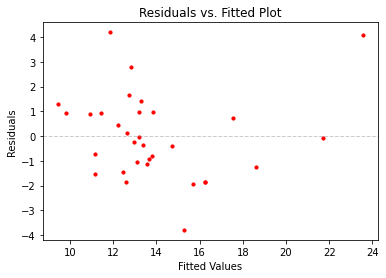

In [173]:
x_variables = ['rtw_earnings_ratio_19',
               'log_Tourism_Spend_2009(£m)',
               'log_Rents/km^2',
               '%Open_Space_2013']
multiple_regression(x_variables)

## K-Means Clustering

In [133]:
clustering_variables = ['rtw_earnings_ratio_19',
                        'log_Tourism_Spend_2009(£m)',
                        'log_Rents/km^2',
                        '%Open_Space_2013',
                        'rtw_earnings_ratio_change_02-19',
                        'House_Earnings_Ratio']

In [134]:
clustering_data = full_data[clustering_variables] # We only want the coordinates for clustering

# I need the data to be on the same scale

std_clustering_data = pd.DataFrame()

std_clustering_data[clustering_variables] = StandardScaler().fit_transform(full_data[clustering_variables])

    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3
    ...k-value of 4
    ...k-value of 5
    ...k-value of 6
    ...k-value of 7
    ...k-value of 8
    ...k-value of 9
    ...k-value of 2
    ...k-value of 3


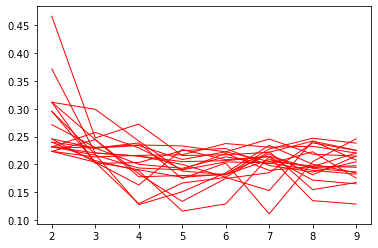

In [135]:
for i in range(1,20):
    kValues = []
    SilScores = []
    for k in range(2,10): # For k values between 2 and 10
        print(f'    ...k-value of {k}') # Update for the user
        kmeans_model = sklc.KMeans(n_clusters=k, n_init=1, random_state=i).fit(std_clustering_data) # Run the KMeans clustering algorithm
            #random_state is set for reproducibility
        labels = kmeans_model.labels_ # Extract the labels for each cluster the points belong to
        score = sklm.silhouette_score(std_clustering_data, labels, metric='euclidean') # Extract the average silhouette scores
        SilScores.append(score) # Add the score to the list
        kValues.append(k) # Add the k Value to the list
    plt.plot(kValues, SilScores, c='r', linewidth=1, linestyle='-')
plt.show()

In [62]:
mylist = [8,7,67,6,5,5,5,5,5]
mylist.index(max(mylist))

2

In [140]:
k = 3
reps = 50
scores = [0]
models = full_data

for model in range(1,reps):
    model_name = f'model_{model}'
    kmeans_model = sklc.KMeans(n_clusters=k, n_init=1, random_state=model).fit(std_clustering_data) # Run the KMeans clustering algorithm
                #random_state is set for reproducibility
    labels = kmeans_model.labels_ # Extract the labels for each cluster the points belong to
    models[model_name] = labels
    score = sklm.silhouette_score(std_clustering_data, labels, metric='euclidean') # Extract the average silhouette scores
    scores.append(score)
    print(f'Model {model}:\n   Average Silhouette Score: {score}')
    
max_index = scores.index(max(scores))
print(f'\nModel {max_index} had the highest average Silhouette Score: {scores[max_index]}')
for c in range(0,k):
    print(f'\nCluster {c+1}:\n')
    cluster_areas = models[(models[f'model_{max_index}'] == c)]
    print(cluster_areas['Area'].values)

Model 1:
   Average Silhouette Score: 0.2991612188434192
Model 2:
   Average Silhouette Score: 0.25759144299621645
Model 3:
   Average Silhouette Score: 0.22949951928959134
Model 4:
   Average Silhouette Score: 0.23075660697516215
Model 5:
   Average Silhouette Score: 0.2069302374833188
Model 6:
   Average Silhouette Score: 0.2206922222302161
Model 7:
   Average Silhouette Score: 0.20410116281406604
Model 8:
   Average Silhouette Score: 0.22949951928959134
Model 9:
   Average Silhouette Score: 0.20399387938209737
Model 10:
   Average Silhouette Score: 0.20192695588221757
Model 11:
   Average Silhouette Score: 0.21673325474376237
Model 12:
   Average Silhouette Score: 0.24472318061639123
Model 13:
   Average Silhouette Score: 0.24766673834627717
Model 14:
   Average Silhouette Score: 0.21798370384023716
Model 15:
   Average Silhouette Score: 0.24472318061639123
Model 16:
   Average Silhouette Score: 0.20399387938209737
Model 17:
   Average Silhouette Score: 0.2134311493825637
Model 18:
